
Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 9999:
Image - Min Value: 3 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile
Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.


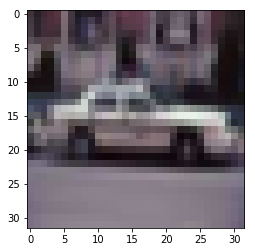

In [77]:
from urllib.request import urlretrieve
#import urllib

from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

"""
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


# In[2]:


import pickle
import numpy as np
import matplotlib.pyplot as plt
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


# In[3]:


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))

    plt.imshow(sample_image)


# In[54]:


#get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 9999
features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
imageTest = features[0:100]

display_stats(cifar10_dataset_folder_path, batch_id, sample_id)


# In[5]:


features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
sample_image = features[0]
#plt.imshow(sample_image)
X_test = features[0:100]
y_test = labels[0:100]
X_test.shape


# In[6]:


from sklearn.utils import shuffle

X_test, y_test = shuffle(X_test, y_test)


# In[7]:


import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128


# In[13]:

import os
session = tf.Session()

sigma = 0.1


def restoreWeights():
    for wIdx in range(0, len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
        session.run(assign_op)

    for wIdx in range(0, len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wOrigFc[wIdx])
        session.run(assign_op)





saver = tf.train.Saver()
save_dir = 'checkpoints_lenetMinst/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
#session.run(tf.global_variables_initializer())
init = tf.global_variables_initializer()
session.run(init)
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())



from tensorflow.contrib.layers import flatten

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    #layerConvOut = layer

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    #layer += biases

    return layer, weights, biases

def pooling_relu(input,              # The previous layer.
                  use_pooling=True):  # Use 2x2 max-pooling.


    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=input,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer


def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

a = tf.placeholder(tf.float32, (100,32,32,3))
x_image = tf.reshape(a, [-1, 32, 32, 1])

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)
keep_prob = tf.placeholder(tf.float32)
init = tf.global_variables_initializer()
session.run(init)






In [78]:
# In[16]:

rate = 0.001
num_channels = 1
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

# convolution layer1
filter_size1 = 3
num_filters1 = 64

# convolution layer2
filter_size2 = 3
num_filters2 = 128

#convolution layer3
filter_size3 = 3
num_filters3 = 256


fc_size1 = 1024
fc_size2 = 1024
fc_size3 = 10


layer_conv1, weights_conv1,biases_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1)

layer_conv1_biases = layer_conv1 + biases_conv1
pool1 = max_pool('pool1', layer_conv1_biases, k=2)
norm1 = norm('norm1', pool1, lsize=4)
_dropout = keep_prob
norm1 = tf.nn.dropout(norm1, _dropout)
layer_conv2, weights_conv2,biases_conv2 = \
    new_conv_layer(input=norm1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2)

layer_conv2_biases = layer_conv2 + biases_conv2
pool2 = max_pool('pool2', layer_conv2_biases, k=2)
    # Apply Normalization
norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
norm2 = tf.nn.dropout(norm2, _dropout)

layer_conv3, weights_conv3,biases_conv3 = \
    new_conv_layer(input=norm2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3)

layer_conv3_biases = layer_conv3 + biases_conv3

pool3 = max_pool('pool3', layer_conv3, k=2)
    # Apply Normalization
norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
norm3 = tf.nn.dropout(norm3, _dropout)
layer_flat, num_features = flatten_layer(norm3)

layer_fc1,weights_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)
layer_flat1, num_features1 = flatten_layer(layer_fc1)
layer_fc2,weights_fc2 = new_fc_layer(input=layer_flat1,
                         num_inputs=num_features1,
                         num_outputs=fc_size2,
                         use_relu=True)
layer_flat2, num_features2 = flatten_layer(layer_fc2)
layer_fc3,weights_fc3 = new_fc_layer(input=layer_flat2,
                         num_inputs=num_features2,
                         num_outputs=fc_size3,
                         use_relu=True)
y_pred = tf.nn.softmax(layer_fc3)
y_pred_cls = tf.argmax(y_pred, axis=1)

session.run(tf.global_variables_initializer())





In [79]:
weights_conv1

In [80]:
########################
weightsConvMat = [weights_conv1,weights_conv2, weights_conv3]
weightsFcMat = [weights_fc1, weights_fc2, weights_fc3]
wConvOrig1 = session.run(weights_conv1)
wConv1 = session.run(weights_conv1)
wConvOrig2 = session.run(weights_conv2)
wConv2 = session.run(weights_conv2)
wConvOrig3 = session.run(weights_conv3)
wConv3 = session.run(weights_conv3)
wFcOrig1 = session.run(weights_fc1)
wFc1 = session.run(weights_fc1)
wFcOrig2 = session.run(weights_fc2)
wFc2 = session.run(weights_fc2)
wFcOrig3 = session.run(weights_fc3)
wFc3 = session.run(weights_fc3)

wOrigConv = [wConvOrig1, wConvOrig2, wConvOrig3 ]
wOrigFc = [wFcOrig1, wFcOrig2, wFcOrig3]
wConv = [wConv1, wConv2, wConv3]
wFc = [wFc1, wFc2, wFc3]

#######################


#session.run(tf.global_variables_initializer())




In [81]:
wDiffConv = []+ wOrigConv
wDiffFc = []+ wOrigFc

In [82]:
def changeOrig(wtListConv,wtListFc):
    import math
    num = len(wtListConv)


    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        #stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))

                        if(wtMat[j,k,c,i])<0:
                            wtMat[j,k,c,i] = -1 * wtMat[j,k,c,i]


    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]

        for i in range(0,xlen):
            j=0
            while j<ylen:
               # stepper = pow(10.0, digits)
               # wtMat[i,j]=math.trunc(stepper*wtMat[i,j]) / stepper
                if wtMat[i,j]<0:
                    wtMat[i,j] = -1 * wtMat[i,j]
                j=j+1;



# original filters are changed to all positive here
changeOrig(wOrigConv, wOrigFc)


In [83]:
# APPROXIMATION TECHNIQUES

def roundToX(wtListConv, wtListFc, x):
    import math
    from math import log10, floor
    num = len(wtListConv)


    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        #stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        #num = wtMat[j,k,c,i]
                        wtMat[j,k,c,i] = round(wtMat[j,k,c,i], x -int(floor(log10(abs(wtMat[j,k,c,i])))))
                        #wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper


    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]

        for i in range(0,xlen):
            j=0
            while j<ylen:
                #stepper = pow(10.0, digits)
                wtMat[i,j]=round(wtMat[i,j], x -int(floor(log10(abs(wtMat[i,j])))))
                j=j+1;

# here, we assign the approximation technique to our filters and make them positive
roundToX(wConv, wFc, 5)
changeOrig(wConv, wFc)

In [84]:
wOrigConv

[array([[[[1.52695719e-02, 8.30437467e-02, 3.02610397e-02,
           9.77029651e-03, 7.59341661e-03, 3.13563906e-02,
           6.44251704e-02, 6.31137937e-03, 6.15404621e-02,
           7.62377307e-02, 5.84029630e-02, 4.61052209e-02,
           4.48114537e-02, 2.76362244e-02, 7.82385692e-02,
           6.41775271e-03, 3.08501553e-02, 5.12197390e-02,
           8.85694847e-03, 4.52451501e-03, 6.80578640e-04,
           3.78319584e-02, 4.39469405e-02, 6.70164376e-02,
           3.61131914e-02, 3.52115147e-02, 7.22103640e-02,
           1.44864870e-02, 4.65146033e-03, 8.39927420e-02,
           3.23399641e-02, 6.43103803e-03, 3.11532449e-02,
           2.45615449e-02, 4.85649370e-02, 5.22946715e-02,
           1.46196354e-02, 1.60747115e-02, 3.47136222e-02,
           1.76771078e-02, 2.21556630e-02, 4.16194908e-02,
           4.91301753e-02, 4.98930216e-02, 7.15094581e-02,
           3.51168402e-02, 3.32277976e-02, 6.60126582e-02,
           1.95263010e-02, 6.44249190e-03, 1.53235265e-0

In [85]:
wConv

[array([[[[1.52696e-02, 8.30437e-02, 3.02610e-02, 9.77030e-03,
           7.59342e-03, 3.13564e-02, 6.44252e-02, 6.31138e-03,
           6.15405e-02, 7.62377e-02, 5.84030e-02, 4.61052e-02,
           4.48115e-02, 2.76362e-02, 7.82386e-02, 6.41775e-03,
           3.08502e-02, 5.12197e-02, 8.85695e-03, 4.52452e-03,
           6.80579e-04, 3.78320e-02, 4.39469e-02, 6.70164e-02,
           3.61132e-02, 3.52115e-02, 7.22104e-02, 1.44865e-02,
           4.65146e-03, 8.39927e-02, 3.23400e-02, 6.43104e-03,
           3.11532e-02, 2.45615e-02, 4.85649e-02, 5.22947e-02,
           1.46196e-02, 1.60747e-02, 3.47136e-02, 1.76771e-02,
           2.21557e-02, 4.16195e-02, 4.91302e-02, 4.98930e-02,
           7.15095e-02, 3.51168e-02, 3.32278e-02, 6.60127e-02,
           1.95263e-02, 6.44249e-03, 1.53235e-03, 5.53879e-02,
           8.71853e-02, 6.53411e-02, 1.51832e-03, 5.37432e-02,
           4.18066e-02, 1.31510e-02, 2.60181e-02, 8.47613e-03,
           8.86507e-02, 4.50447e-02, 1.47040e-02, 6.731

In [86]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)

    for wIdx in range(0,len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)

In [51]:
wConv[0].shape

(3, 3, 1, 64)

In [87]:
dropout = 0.8

In [21]:
conv2

<tf.Tensor 'Relu_13:0' shape=(29997, 10, 10, 16) dtype=float32>

In [13]:
wOrigConv

[array([[[[0.11459605, 0.14867666, 0.1019    , 0.03192712, 0.02109637,
           0.10052023]],
 
         [[0.08008973, 0.12137049, 0.01637979, 0.07015798, 0.01977565,
           0.06851535]],
 
         [[0.03402819, 0.10860671, 0.14983304, 0.14822002, 0.00465381,
           0.08805681]],
 
         [[0.02609474, 0.09197669, 0.05198411, 0.08998647, 0.01815578,
           0.03890263]],
 
         [[0.0164889 , 0.15801427, 0.03714399, 0.00124382, 0.00848418,
           0.16616169]]],
 
 
        [[[0.08319607, 0.06189531, 0.08162319, 0.04325733, 0.15493375,
           0.04858652]],
 
         [[0.00059856, 0.07052442, 0.02017582, 0.15714578, 0.03457211,
           0.02231532]],
 
         [[0.11319782, 0.1414444 , 0.02799654, 0.05684277, 0.10894363,
           0.02267701]],
 
         [[0.12964445, 0.06138369, 0.06477177, 0.14413323, 0.0186928 ,
           0.10960119]],
 
         [[0.09579995, 0.0144631 , 0.19921492, 0.08018848, 0.1002272 ,
           0.16125557]]],
 
 
        [[[0.0

In [88]:
assignFilters(wConv,wFc)

In [ ]:



# In[41]:


def loadValues(numImg):



    feed_dict = {a: imageTest, keep_prob:dropout}
    values_conv1 = session.run(layer_conv1, feed_dict=feed_dict)
    values_conv2 = session.run(layer_conv2, feed_dict=feed_dict)
    values_conv3 = session.run(layer_conv3, feed_dict = feed_dict)
    values_fc1 = session.run(layer_fc1, feed_dict = feed_dict)
    values_fc2 = session.run(layer_fc2, feed_dict = feed_dict)
    values_fc3 = session.run(layer_fc3, feed_dict = feed_dict)
    #values_fc4 = session.run(fc4, feed_dict = feed_dict)
    #values_out = session.run(out, feed_dict = feed_dict)

    valuesConvMat = [values_conv1, values_conv2, values_conv3]
    valuesFcMat = [values_fc1, values_fc2, values_fc3]

    return valuesConvMat, valuesFcMat, numImg

def calculateStaticDiff(wConv, wFc, wOrigConv, wOrigFc):
    for i in range(len(wConv)):
        wDiffConv[i] = abs(wOrigConv[i]-wConv[i])
    for i in range(len(wFc)):
        wDiffFc[i] = abs(wOrigFc[i] - wFc[i])



def calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc):
    wConvSorted = [] + wConv
    wConvOrigSorted = [] + wOrigConv
    wFcSorted = [] + wFc
    wFcOrigSorted = [] + wOrigFc
    for i in range(len(wConv)):
        wConvSorted[i] = np.sort(wConv[i])
        wConvOrigSorted[i] = np.sort(wOrigConv[i])
    for i in range(len(wFc)):
        wFcSorted[i] = np.sort(wFc[i])
        wFcOrigSorted[i] = np.sort(wOrigFc[i])
    for i in range(len(wConv)):
        wDiffConv[i] = abs(wConvOrigSorted[i] - wConvSorted[i])
        wDiffConv[i] = np.sort(wDiffConv[i])
    for i in range(len(wFc)):
        wDiffFc[i] = abs(wFcOrigSorted[i] - wFcSorted[i])
        wDiffFc[i] = np.sort(wDiffFc[i])





calculateStaticDiff(wConv, wFc, wOrigConv, wOrigFc)

def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means/numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum


    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)



    #print(result.shape)
    average = [x / numImg for x in posME]
    averageSorted = np.sort(average)
    return average, averageSorted


# In[50]:


def calculateFCME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means/numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    posList = []
    for i in meanSum:
        if i<0:
            i = i*-1
        posList.append(i)
    average = [x / numImg for x in posList]
    averageSorted = np.sort(average)
    return average, averageSorted

session.run(tf.global_variables_initializer())
assignFilters(wConv,wFc)
assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)

###### LAYER 1 ######
valuesConvMat, valuesFcMat, numImg = loadValues(100)
MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])
MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])
#MEConv1 = calculateConvMEDynamic(valuesConvMat[0])
#MEFullyConnected1 = calculateFCMEDynamic(valuesFcMat[0])

assignFilters(wConv,wFc)
assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)

###### LAYER 2 ######
valuesConvMat,valuesFcMat,numImg = loadValues(100)
MEConv2,MEConv2Sorted = calculateConvME(valuesConvMat[1])
MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])
#MEConv2 = calculateConvMEDynamic(valuesConvMat[1])
#MEFullyConnected2 = calculateFCMEDynamic(valuesFcMat[1])


assign_op = weightsFcMat[2].assign(wDiffFc[2])
session.run(assign_op)
valuesConvMat,valuesFcMat,numImg = loadValues(100)
MEConv3, MEConv3Sorted = calculateConvME(valuesConvMat[2])
#MEFullyConnected3 = calculateFCMEDynamic(valuesFcMat[2])
MEFullyConnected3, MEFullyConnected3Sorted = calculateFCME(valuesFcMat[2])

######### loadvalues ends here #########

MEFullyConnected1Graphs.append(MEFullyConnected1Sorted)
MEFullyConnected2Graphs.append(MEFullyConnected2Sorted)
MEFullyConnected3Graphs.append(MEFullyConnected3Sorted)
MEConv1Graphs.append(MEConv1Sorted)
MEConv2Graphs.append(MEConv2Sorted)

def plotMEConvolution(ME1, ME2):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')


# In[52]:


def plotMEFullyConnected(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    plt.bar(x3 + d2, ME3, color='r', align = 'center')




print("this is the conv for static analysis")

### copy the output to a file####
##np.savetxt('mefc1', MEFullyConnected1Graphs[0], delimiter=',')


##### dynamic diff ######



In [15]:
calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc)
session.run(tf.global_variables_initializer())
assignFilters(wConv,wFc)
assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)

###### LAYER 1 ######
valuesConvMat, valuesFcMat, numImg = loadValues(100)
MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])
MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])
#MEConv1 = calculateConvMEDynamic(valuesConvMat[0])
#MEFullyConnected1 = calculateFCMEDynamic(valuesFcMat[0])

assignFilters(wConv,wFc)
assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)

###### LAYER 2 ######
valuesConvMat,valuesFcMat,numImg = loadValues(100)
MEConv2,MEConv2Sorted = calculateConvME(valuesConvMat[1])
MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])
#MEConv2 = calculateConvMEDynamic(valuesConvMat[1])
#MEFullyConnected2 = calculateFCMEDynamic(valuesFcMat[1])


assign_op = weightsFcMat[2].assign(wDiffFc[2])
session.run(assign_op)
valuesConvMat,valuesFcMat,numImg = loadValues(100)
#MEConv1 = calculateConvMEDynamic(valuesConvMat[0])
#MEFullyConnected3 = calculateFCMEDynamic(valuesFcMat[2])
MEFullyConnected3, MEFullyConnected3Sorted = calculateFCME(valuesFcMat[2])

######### loadvalues ends here #########



MEFullyConnected1Graphs.append(MEFullyConnected1Sorted)
MEFullyConnected2Graphs.append(MEFullyConnected2Sorted)
MEFullyConnected3Graphs.append(MEFullyConnected3Sorted)
MEConv1Graphs.append(MEConv1Sorted)
MEConv2Graphs.append(MEConv2Sorted)

##np.savetxt('mefc2', MEFullyConnected1Graphs[1], delimiter=',')
def write(data, outfile):
        f = open(outfile, "w+b")
        pickle.dump(data, f)
        f.close()
print("this is the conv for dynamic analysis")




this is the conv for dynamic analysis


In [ ]:
MEFullyConnected1Graphs[1] 

In [48]:
wOrigConv

[array([[[[0.02817008, 0.11392275, 0.09441574, 0.00459376, 0.00955311,
           0.09215598]],
 
         [[0.06178182, 0.0397076 , 0.01752221, 0.0515107 , 0.05774866,
           0.06868045]],
 
         [[0.15165661, 0.06536669, 0.01257197, 0.05276909, 0.0504104 ,
           0.05459616]],
 
         [[0.01342579, 0.01787867, 0.10582568, 0.01057119, 0.0387093 ,
           0.096733  ]],
 
         [[0.07962853, 0.02745186, 0.07928177, 0.00148148, 0.1311553 ,
           0.02099615]]],
 
 
        [[[0.10246426, 0.06959071, 0.00076337, 0.14714983, 0.17059927,
           0.13737701]],
 
         [[0.05846789, 0.18188195, 0.05308583, 0.01568363, 0.17482214,
           0.00768497]],
 
         [[0.02320319, 0.08465756, 0.00163694, 0.12567328, 0.08186051,
           0.12997656]],
 
         [[0.06276473, 0.02828312, 0.08858628, 0.02529631, 0.01100602,
           0.05914425]],
 
         [[0.09108686, 0.03662999, 0.0895416 , 0.02649937, 0.1864846 ,
           0.00170443]]],
 
 
        [[[0.0

In [17]:
def plotDiff(ME1, ME2):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
   # x3 = np.arange(len(ME3))
    plt.bar(x1, ME1, color = 'black', align = 'center', alpha = 1)
    plt.bar(x2, ME2, color = 'red', align = 'center', alpha = 0.7)
    #plt.bar(x3, ME3, color = 'green', align = 'center', alpha = 0.6)

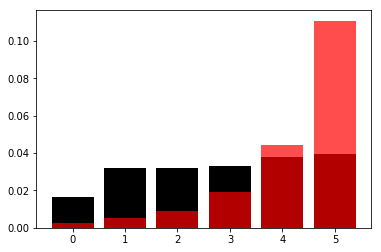

In [18]:
plotDiff(MEConv1Graphs[0], MEConv1Graphs[1])

In [36]:
wConv

[array([[[[3.81601e-02, 1.11231e-01, 6.53935e-02, 4.44135e-02,
           7.65232e-02, 3.40715e-02]],
 
         [[6.37959e-02, 1.06841e-01, 3.13345e-02, 7.14046e-02,
           2.58488e-02, 3.11292e-02]],
 
         [[1.17160e-02, 5.33358e-02, 1.46880e-01, 2.07808e-02,
           1.07788e-02, 9.68531e-02]],
 
         [[5.26316e-02, 4.88806e-02, 2.81239e-02, 4.69984e-02,
           2.12468e-02, 5.29376e-02]],
 
         [[4.79066e-02, 9.60194e-02, 1.90001e-02, 4.69588e-02,
           1.62490e-02, 4.25785e-02]]],
 
 
        [[[9.47454e-02, 3.96414e-02, 1.41870e-02, 1.20346e-01,
           9.77815e-02, 9.84836e-02]],
 
         [[1.34101e-03, 2.38375e-03, 2.44204e-02, 6.58117e-02,
           7.12825e-02, 1.25115e-01]],
 
         [[1.10799e-01, 8.99589e-02, 4.73282e-02, 1.23550e-01,
           2.02941e-02, 1.33964e-01]],
 
         [[1.23404e-01, 7.22355e-04, 8.13947e-02, 2.13232e-02,
           1.40818e-01, 5.09099e-02]],
 
         [[9.49236e-02, 1.34784e-01, 4.34952e-02, 3.48600e-02

In [37]:
wOrigConv

[array([[[[3.81601e-02, 1.11231e-01, 6.53935e-02, 4.44135e-02,
           7.65232e-02, 3.40715e-02]],
 
         [[6.37959e-02, 1.06841e-01, 3.13345e-02, 7.14046e-02,
           2.58488e-02, 3.11292e-02]],
 
         [[1.17160e-02, 5.33358e-02, 1.46880e-01, 2.07808e-02,
           1.07788e-02, 9.68531e-02]],
 
         [[5.26316e-02, 4.88806e-02, 2.81239e-02, 4.69984e-02,
           2.12468e-02, 5.29376e-02]],
 
         [[4.79066e-02, 9.60194e-02, 1.90001e-02, 4.69588e-02,
           1.62490e-02, 4.25785e-02]]],
 
 
        [[[9.47454e-02, 3.96414e-02, 1.41870e-02, 1.20346e-01,
           9.77815e-02, 9.84836e-02]],
 
         [[1.34101e-03, 2.38375e-03, 2.44204e-02, 6.58117e-02,
           7.12825e-02, 1.25115e-01]],
 
         [[1.10799e-01, 8.99589e-02, 4.73282e-02, 1.23550e-01,
           2.02941e-02, 1.33964e-01]],
 
         [[1.23404e-01, 7.22355e-04, 8.13947e-02, 2.13232e-02,
           1.40818e-01, 5.09099e-02]],
 
         [[9.49236e-02, 1.34784e-01, 4.34952e-02, 3.48600e-02